## *Import Libraries*

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import warnings

In [3]:
warnings.filterwarnings('ignore')

## *Load Data*

In [4]:
!unzip '/content/drive/MyDrive/Craiglist.zip'

Archive:  /content/drive/MyDrive/Craiglist.zip
  inflating: Craiglist/scaler_target.file  
  inflating: Craiglist/test.parquet  
  inflating: Craiglist/val.parquet   
  inflating: Craiglist/train.parquet  


In [6]:
train = pd.read_parquet('/content/Craiglist/train.parquet')
test = pd.read_parquet('/content/Craiglist/test.parquet')
val = pd.read_parquet('/content/Craiglist/val.parquet')

## *Split Data*

In [7]:
def load_input_output(df):

  X = df.drop(columns = "price")
  y = df.price.values.reshape(-1,1)

  return X,y

In [8]:
X_train,y_train = load_input_output(train)
X_test,y_test = load_input_output(test)
X_val,y_val = load_input_output(val)

## Array Transform

In [9]:
def array(x):
  return np.asarray(x)

In [10]:
X_train,y_train = array(X_train),array(y_train)
X_test,y_test = array(X_test),array(y_test)
X_val,y_val = array(X_val),array(y_val)

In [14]:
X_train.shape[0],X_test.shape[0],X_val.shape[0]

(84934, 26543, 21234)

## Dataset and Dataloader Pytorch

In [15]:
import torch

In [16]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self,x,y):
        self.x = torch.from_numpy(x).float().to('cuda')
        self.y = torch.from_numpy(y).float().to('cuda')
        
    def __len__(self):
        return self.x.shape[0]
    
    def __getitem__(self,index):
        return self.x[index],self.y[index]

In [17]:
trainDataset = Dataset(X_train,y_train)
testDataset = Dataset(X_test,y_test)

In [18]:
trainDataloader = torch.utils.data.DataLoader(trainDataset,
                                              batch_size = 32,
                                              shuffle = True)

testDataloader = torch.utils.data.DataLoader(testDataset,
                                              batch_size = 16,
                                              shuffle = True)

## *Creation Model*

In [19]:
import torch.nn as nn
import torch.nn.functional as F

In [20]:
X_train.shape[1]

6650

Number of predictor variables.

Input dim

In [22]:
class Model(nn.Module):
    def __init__(self):
        super(Model,self).__init__()

        self.fc1 = nn.Linear(in_features = 6650,out_features = 128)
        self.fc2 = nn.Linear(in_features = 128,out_features = 64)
        self.fc3 = nn.Linear(in_features= 64,out_features=32)
        self.output = nn.Linear(in_features = 32,out_features = 1)
    
    def forward(self,x):
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.dropout(x,0.3)
    
        
        return self.output(x)

The model consists of three hidden layers, where the model is expected to receive 6664 variables and then a relu activation function will be performed to break the linearity of the data, we will use the Drouput function to deactivate a certain percentage of neurons in order for the model to find alternative routes and avoid data overfitting.

In [23]:
model = Model()
optimizer = torch.optim.Adam(model.parameters(),lr = 0.0001)
loss = nn.MSELoss()

We will use the Adam optimizer that generally gives very good results quickly and accompanied by a small learning rate to avoid overfitting, also using a small learning rate has the advantage of being able to use more training epochs.

In [24]:
model.to('cuda')

Model(
  (fc1): Linear(in_features=6650, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (output): Linear(in_features=32, out_features=1, bias=True)
)

We pass the model to the GPU for more efficient training

## *Train Model*

In [25]:
def train(dataloader):
    
    model.train()
    for xi,yi in dataloader:
        xi = xi.to('cuda')
        yi = yi.to('cuda')
        pred = model(xi)
        loss_fc = loss(pred,yi)
        
        optimizer.zero_grad()
        loss_fc.backward()
        optimizer.step()
        
    return loss_fc.item()


@torch.no_grad()
def test(dataloader):
    
    model.eval()
    
    for xi,yi in dataloader:
        xi = xi.to('cuda')
        yi = yi.to('cuda')
        pred = model(xi)
        loss_fc = loss(pred,yi)
    
        
    return loss_fc.item()

In [27]:
epochs = np.arange(1,60+1,1)
loss_train_list,loss_test_list,epoch_list = [],[],[]

## *Train Loop*

In [28]:
for epoch in epochs:
    
    loss_train,loss_test = train(trainDataloader),test(testDataloader)
    
    loss_train_list.append(loss_train)
    loss_test_list.append(loss_test)
    epoch_list.append(epoch)


    print(f'Epoch:  {epoch} loss train: {loss_train} loss test: {loss_test} ')

Epoch:  1 loss train: 0.0922481119632721 loss test: 0.0788785070180893 
Epoch:  2 loss train: 0.21399298310279846 loss test: 0.1356920301914215 
Epoch:  3 loss train: 0.11474005877971649 loss test: 0.08396702259778976 
Epoch:  4 loss train: 0.18661288917064667 loss test: 0.0774383619427681 
Epoch:  5 loss train: 0.05093724653124809 loss test: 0.03596118465065956 
Epoch:  6 loss train: 0.03828100860118866 loss test: 0.09269878268241882 
Epoch:  7 loss train: 0.08329374343156815 loss test: 0.021358689293265343 
Epoch:  8 loss train: 0.1873924434185028 loss test: 0.10577169060707092 
Epoch:  9 loss train: 0.08371828496456146 loss test: 0.09416455775499344 
Epoch:  10 loss train: 0.0960337221622467 loss test: 0.07220326364040375 
Epoch:  11 loss train: 0.019701335579156876 loss test: 0.05767995864152908 
Epoch:  12 loss train: 0.16362690925598145 loss test: 0.341941773891449 
Epoch:  13 loss train: 0.2846006155014038 loss test: 0.05207708477973938 
Epoch:  14 loss train: 0.1598750799894333

## *History*

In [29]:
history = pd.DataFrame()
history['epoch'] = epoch_list
history['loss_train'] = loss_train_list
history['loss_test'] = loss_test_list

In [30]:
plt.style.use('ggplot')

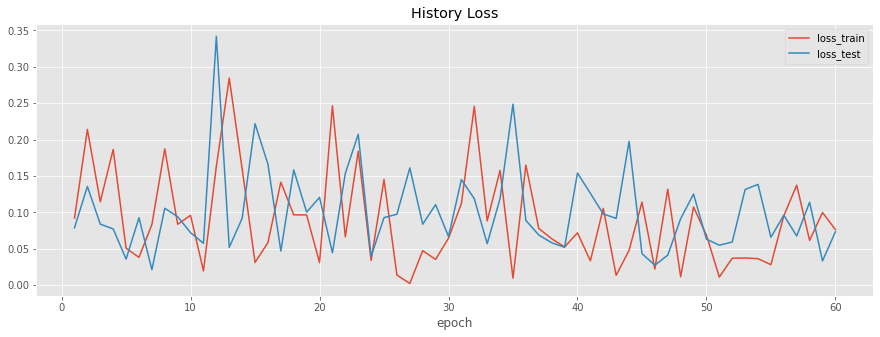

In [31]:
fig,ax = plt.subplots(1,1,figsize = (15,5))
ax.set_title('History Loss')
history.plot(x = "epoch",y = "loss_train",ax = ax)
history.plot(x = "epoch",y = "loss_test",ax = ax)
plt.show()

The loss function for the training and validation data behave almost at the same time, at first glance the model does not seem to suffer overfitting.

## *Evaluate*

In [32]:
X_val =  torch.from_numpy(X_val).float().to('cuda')

Since we are deploying the model to the GPU we also have to do the same for the data.

In [33]:
pred_train = model(trainDataset.x).detach().to('cpu')
pred_test = model(testDataset.x).detach().to('cpu')
pred_val = model(X_val).detach().to('cpu')

We generate predictions and move them to the CPU to save resources with the GPU.

In [34]:
import joblib

In [35]:
scaler_y = joblib.load('/content/Craiglist/scaler_target.file')

We load the previously saved objects, to bring the data to its real scale and have the true metrics.

In [36]:
pred_train_inv = scaler_y.inverse_transform(pred_train)
pred_test_inv = scaler_y.inverse_transform(pred_test)
pred_val_inv = scaler_y.inverse_transform(pred_val)

In [37]:
y_train_inv = scaler_y.inverse_transform(y_train)
y_test_inv = scaler_y.inverse_transform(y_test)
y_val_inv = scaler_y.inverse_transform(y_val)

Perform scale adjustment.

In [38]:
from sklearn.metrics import mean_squared_error,r2_score

### *Mean Squared Error*

Represents the average value of error between the original value and the predicted.

In [39]:
def MSE(y_true,y_pred):
    
    return np.round(np.sqrt(mean_squared_error(y_true,y_pred)))

In [40]:
mse_train = MSE(y_train_inv,pred_train_inv)
mse_test = MSE(y_test_inv,pred_test_inv)
mse_val = MSE(y_val_inv,pred_val_inv)

In [41]:
print(f'MSE Train: {mse_train}')
print(f'MSE Test:  {mse_test}')
print(f'MSE Val:   {mse_val}')

MSE Train: 3270.0
MSE Test:  3845.0
MSE Val:   3894.0


They have an MSE comparable to each other, so the model does not present an overfit.

## *R2*

In [42]:
r2_train = r2_score(y_train_inv,pred_train_inv)
r2_test = r2_score(y_test_inv,pred_test_inv)
r2_val = r2_score(y_val_inv,pred_val_inv)

In [43]:
print(f'R2 Train: {r2_train}')
print(f'R2 Test:  {r2_test}')
print(f'R2 Val:   {r2_val}')

R2 Train: 0.9295433372772126
R2 Test:  0.9012089394292991
R2 Val:   0.9014954061659353


The model has an excellent percentage of explanation.

In [44]:
df_pred = pd.DataFrame({'true_values':y_test_inv.flatten(),
                        'predicted_values':pred_test_inv.flatten()})

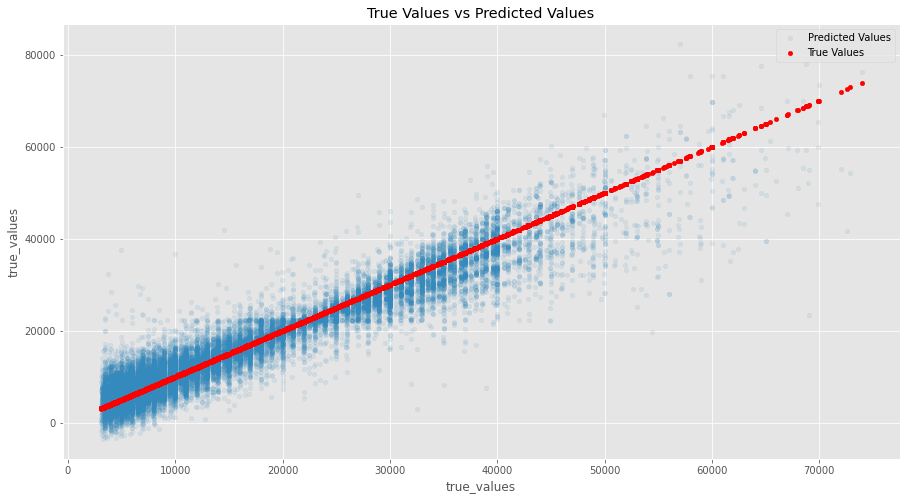

In [45]:
fig,ax = plt.subplots(1,1,figsize = (15,8))

ax.set_title('True Values vs Predicted Values')

df_pred.plot(kind = "scatter",
             x = "true_values",
             y = "predicted_values",
             alpha = 0.1,
             label = "Predicted Values",
             ax = ax)

df_pred.plot(kind = "scatter",
             x = "true_values",
             y = "true_values",
             label = "True Values",
             c = "red",
             ax = ax)
plt.legend()

plt.show()

In [46]:
df_pred.sample(n = 20,random_state = 42)

,true_values,predicted_values
26041,21995.0,22234.535039
19998,42590.0,44362.457016
7356,9600.0,7181.779110
16431,6750.0,9711.490576
23258,31990.0,30655.017852
16327,32595.0,28482.357768
16067,16995.0,14841.183719
23181,29999.0,26696.743968
18884,11900.0,8182.175075
6607,16000.0,13566.652306


The model generates very good predictions that are very close to the original value.

## *Save Model*

In [47]:
model.to('cpu')

Model(
  (fc1): Linear(in_features=6650, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (output): Linear(in_features=32, out_features=1, bias=True)
)

In [48]:
torch.save(model.state_dict(),'craiglist_model.pth')